# PyCaret Anomaly Detection Tutorial

**Dataset:** Credit Card Fraud Detection  
**Source:** Kaggle - European Credit Card Transactions  
**Task:** Detect fraudulent transactions using unsupervised anomaly detection

---

## What is Anomaly Detection?

Anomaly detection identifies rare items, events, or observations that differ significantly from the majority of the data. This tutorial demonstrates:

- **Isolation Forest** - Tree-based anomaly detection
- **K-Nearest Neighbors** - Distance-based detection  
- **Local Outlier Factor** - Density-based detection
- **One-Class SVM** - Support vector-based detection

---

## Environment Setup

In [1]:
# Verify environment
import sys
print(f"Python version: {sys.version}")

import pycaret
print(f"PyCaret version: {pycaret.__version__}")

Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
PyCaret version: 3.3.2


## Load Dataset

The Credit Card Fraud dataset contains transactions made by European cardholders in September 2013.  
Features V1-V28 are PCA transformations to protect user identities.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# Setup data directory
data_dir = Path('../datasets/anomaly')
data_dir.mkdir(parents=True, exist_ok=True)
data_path = data_dir / 'creditcard.csv'

# Download from Kaggle if not already present
if not data_path.exists():
    print(f"📥 Downloading dataset from Kaggle...")
    
    # Check for Kaggle credentials
    kaggle_json = Path.home() / '.kaggle' / 'kaggle.json'
    
    if not kaggle_json.exists():
        print("⚠️  Kaggle credentials not found!")
        print("\nTo download datasets automatically, you need Kaggle API credentials:")
        print("1. Go to https://www.kaggle.com/settings")
        print("2. Scroll to 'API' section and click 'Create New API Token'")
        print("3. This downloads kaggle.json")
        print("4. Place it in ~/.kaggle/kaggle.json")
        print("   mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json")
        raise Exception("Please set up Kaggle credentials to download the dataset")
    else:
        # Download using Kaggle API
        import kaggle
        print(f"Downloading from Kaggle: mlg-ulb/creditcardfraud")
        kaggle.api.dataset_download_files(
            'mlg-ulb/creditcardfraud',
            path=data_dir,
            unzip=True,
            quiet=False
        )
        print(f"✅ Dataset downloaded to {data_dir}")
else:
    print(f"✅ Dataset already exists at {data_path}")

# Load the data
print(f"\n📊 Loading dataset...")
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"\nFeatures: {df.columns.tolist()}")
df.head()

# OPTIMIZATION: Sample dataset for faster execution
# Keep 50,000 rows (stratified by Class to preserve fraud ratio)
if len(df) > 50000:
    from sklearn.model_selection import train_test_split
    print(f"\n⚡ Sampling dataset from {len(df):,} to 50,000 rows for faster execution...")
    df, _ = train_test_split(
        df,
        train_size=50000,
        stratify=df["Class"] if "Class" in df.columns else None,
        random_state=42
    )
    print(f"✅ Sampled dataset shape: {df.shape}")
    if "Class" in df.columns:
        fraud_ratio = df["Class"].mean()
        print(f"   Fraud ratio preserved: {fraud_ratio:.4f}")

✅ Dataset already exists at ../datasets/anomaly/creditcard.csv

📊 Loading dataset...


Dataset shape: (284807, 31)

Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']



⚡ Sampling dataset from 284,807 to 50,000 rows for faster execution...
✅ Sampled dataset shape: (50000, 31)
   Fraud ratio preserved: 0.0017


In [3]:
# Check class distribution
print("Class distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {df['Class'].mean() * 100:.3f}%")

Class distribution:
Class
0    49914
1       86
Name: count, dtype: int64

Fraud percentage: 0.172%


## Data Preprocessing

For anomaly detection, we'll:
- Remove the 'Class' column (since this is unsupervised learning)
- Use a sample for faster training (optional)
- Keep Time and Amount features along with V1-V28

In [4]:
# For faster training, you can sample the data
# Uncomment the next line to use a sample
# df = df.sample(n=50000, random_state=42)

# Store actual labels for evaluation (not used in training)
actual_labels = df['Class'].copy()

# Remove the target column for unsupervised learning
df_unsupervised = df.drop('Class', axis=1)

print(f"Training data shape: {df_unsupervised.shape}")
df_unsupervised.head()

Training data shape: (50000, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
29784,35628.0,-1.370413,1.095589,-0.668018,-0.024219,1.675652,3.823629,-0.634559,1.836666,-0.485368,...,0.037331,-0.151058,-0.609795,0.027077,0.986022,0.079739,-0.463951,0.063528,0.006793,38.31
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.150818,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89
137061,81998.0,-1.789123,0.941366,1.432897,-1.318458,-0.450124,-1.290731,0.933642,-0.306360,0.917978,...,0.478102,-0.292198,-0.202022,-0.017159,0.740137,-0.183085,0.692176,0.488185,0.418299,70.00
53715,46114.0,-0.711379,-1.431688,0.630874,-2.551985,0.509280,-0.565154,0.258866,-0.289951,-2.680067,...,0.258200,-0.361539,-1.064836,0.435373,-0.932473,-0.459677,-0.759301,-0.094306,-0.053401,145.50
42739,41224.0,1.303287,1.023966,-3.187599,0.468391,3.353988,2.431416,0.184510,0.622721,-0.556254,...,0.078229,-0.265551,-0.823366,-0.241908,0.674554,1.012236,-0.278656,0.041260,0.089912,1.00


## PyCaret Setup

Initialize the anomaly detection environment with PyCaret.

In [5]:
from pycaret.anomaly import *

# Setup anomaly detection
anomaly_setup = setup(
    data=df_unsupervised,
    session_id=42,
    normalize=True,  # Normalize features for better detection
    verbose=True
)

,Description,Value
0,Session id,42
1,Original data shape,"(50000, 30)"
2,Transformed data shape,"(50000, 30)"
3,Numeric features,30
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


## Model Training

Let's create and compare multiple anomaly detection models.

### 1. Isolation Forest

Isolation Forest isolates anomalies by randomly selecting features and split values.

In [6]:
# Create Isolation Forest model
# fraction parameter is the expected proportion of outliers (0.002 = 0.2%)
iforest = create_model(
    'iforest',
    fraction=0.002  # Adjust based on known fraud rate
)

print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.002,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=42, verbose=0)


In [7]:
# Assign anomaly labels
iforest_results = assign_model(iforest)

# Show detected anomalies
print(f"Anomalies detected: {iforest_results['Anomaly'].sum()}")
print(f"\nAnomaly distribution:")
print(iforest_results['Anomaly'].value_counts())

iforest_results.head(10)

Anomalies detected: 100

Anomaly distribution:
Anomaly
0    49900
1      100
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Anomaly,Anomaly_Score
29784,35628.0,-1.370413,1.095589,-0.668018,-0.024219,1.675653,3.823629,-0.634559,1.836666,-0.485368,...,-0.609795,0.027077,0.986022,0.079739,-0.463951,0.063528,0.006793,38.310001,0,-0.241485
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.889999,0,-0.195997
137061,81998.0,-1.789123,0.941366,1.432897,-1.318458,-0.450124,-1.290731,0.933642,-0.306360,0.917978,...,-0.202022,-0.017159,0.740137,-0.183085,0.692176,0.488185,0.418299,70.000000,0,-0.246442
53715,46114.0,-0.711379,-1.431688,0.630874,-2.551985,0.509280,-0.565154,0.258866,-0.289951,-2.680067,...,-1.064836,0.435373,-0.932473,-0.459677,-0.759301,-0.094306,-0.053401,145.500000,0,-0.226050
42739,41224.0,1.303288,1.023966,-3.187599,0.468391,3.353988,2.431416,0.184510,0.622721,-0.556254,...,-0.823366,-0.241908,0.674554,1.012236,-0.278655,0.041260,0.089912,1.000000,0,-0.176668
167909,118959.0,2.079435,0.057972,-1.753622,0.418052,0.316720,-0.884450,0.087868,-0.153041,0.710701,...,-1.069208,0.350853,0.443416,-0.298244,0.179773,-0.071796,-0.034166,0.890000,0,-0.262238
209539,137608.0,-0.789304,0.107723,0.655574,1.105067,-0.115432,0.773314,-0.833790,0.789969,1.185240,...,0.906606,0.226520,-1.154971,-0.610361,-0.507381,0.084316,0.047703,47.299999,0,-0.210677
269734,163746.0,-0.134683,0.518785,0.964579,0.355104,0.437104,-0.591002,1.022191,-0.272317,0.229757,...,0.575054,0.004129,-0.081314,-0.730483,-0.820768,0.072393,0.014246,46.250000,0,-0.272241
224744,143943.0,2.079452,0.165490,-1.767843,0.368335,0.550175,-0.696191,0.183157,-0.213943,0.466546,...,-0.930856,0.323828,0.326098,-0.242497,0.186283,-0.057982,-0.032292,0.990000,0,-0.273267
87415,61675.0,1.196689,-0.075259,0.081766,0.690997,-0.094079,-0.017219,-0.031813,0.029995,0.537995,...,-0.314486,-0.106366,-0.447657,0.550614,0.431925,-0.023346,0.001163,28.000000,0,-0.290425


### 2. K-Nearest Neighbors (KNN)

KNN detects anomalies based on distance to nearest neighbors.

In [8]:
# Create KNN anomaly detector
knn = create_model('knn', fraction=0.002)

print(knn)

KNN(algorithm='auto', contamination=0.002, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)


In [9]:
# Assign anomaly labels
knn_results = assign_model(knn)

print(f"Anomalies detected: {knn_results['Anomaly'].sum()}")
print(f"\nAnomaly distribution:")
print(knn_results['Anomaly'].value_counts())

Anomalies detected: 100

Anomaly distribution:
Anomaly
0    49900
1      100
Name: count, dtype: int64


### 3. Local Outlier Factor (LOF)

LOF detects anomalies based on local density deviation.

In [10]:
# Create LOF model
lof = create_model('lof', fraction=0.002)

print(lof)

LOF(algorithm='auto', contamination=0.002, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=-1, n_neighbors=20, novelty=True, p=2)


In [11]:
# Assign anomaly labels
lof_results = assign_model(lof)

print(f"Anomalies detected: {lof_results['Anomaly'].sum()}")
print(f"\nAnomaly distribution:")
print(lof_results['Anomaly'].value_counts())

Anomalies detected: 100

Anomaly distribution:
Anomaly
0    49900
1      100
Name: count, dtype: int64


## Visualization

Visualize the anomalies detected by each model.

In [12]:
# Plot 2D projection of anomalies (TSNE)
plot_model(iforest, plot='tsne')

In [13]:
# Plot UMAP projection
plot_model(iforest, plot='umap')

## Model Evaluation

Since we have actual fraud labels, we can evaluate how well our models detected fraud.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_anomaly_detection(results, actual_labels, model_name):
    """Evaluate anomaly detection against actual fraud labels."""
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation")
    print(f"{'='*60}")
    
    # Confusion Matrix
    cm = confusion_matrix(actual_labels, results['Anomaly'])
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(actual_labels, results['Anomaly'], 
                                target_names=['Normal', 'Fraud']))
    
    # Calculate precision and recall
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\nKey Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return {'precision': precision, 'recall': recall, 'f1': f1}

# Evaluate all models
iforest_metrics = evaluate_anomaly_detection(iforest_results, actual_labels, "Isolation Forest")
knn_metrics = evaluate_anomaly_detection(knn_results, actual_labels, "KNN")
lof_metrics = evaluate_anomaly_detection(lof_results, actual_labels, "LOF")


Isolation Forest Evaluation

Confusion Matrix:
[[49843    71]
 [   57    29]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     49914
       Fraud       0.29      0.34      0.31        86

    accuracy                           1.00     50000
   macro avg       0.64      0.67      0.66     50000
weighted avg       1.00      1.00      1.00     50000


Key Metrics:
Precision: 0.2900
Recall: 0.3372
F1-Score: 0.3118

KNN Evaluation

Confusion Matrix:
[[49832    82]
 [   68    18]]

Classification Report:


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     49914
       Fraud       0.18      0.21      0.19        86

    accuracy                           1.00     50000
   macro avg       0.59      0.60      0.60     50000
weighted avg       1.00      1.00      1.00     50000


Key Metrics:
Precision: 0.1800
Recall: 0.2093
F1-Score: 0.1935

LOF Evaluation

Confusion Matrix:
[[49816    98]
 [   84     2]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     49914
       Fraud       0.02      0.02      0.02        86

    accuracy                           1.00     50000
   macro avg       0.51      0.51      0.51     50000
weighted avg       1.00      1.00      1.00     50000


Key Metrics:
Precision: 0.0200
Recall: 0.0233
F1-Score: 0.0215


## Model Comparison


Model Comparison:
           Model  Precision   Recall  F1-Score
Isolation Forest       0.29 0.337209  0.311828
             KNN       0.18 0.209302  0.193548
             LOF       0.02 0.023256  0.021505


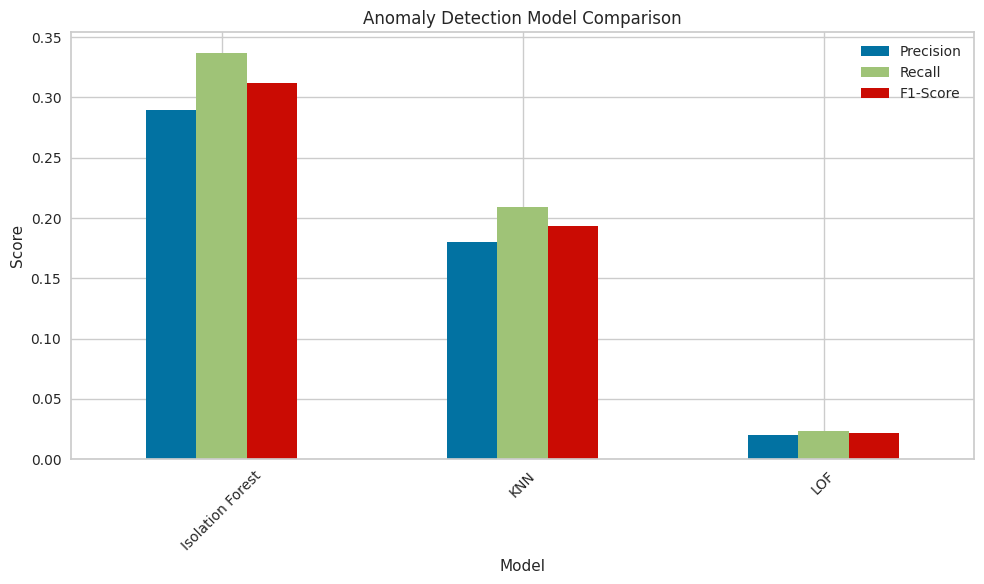

In [15]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'KNN', 'LOF'],
    'Precision': [iforest_metrics['precision'], knn_metrics['precision'], lof_metrics['precision']],
    'Recall': [iforest_metrics['recall'], knn_metrics['recall'], lof_metrics['recall']],
    'F1-Score': [iforest_metrics['f1'], knn_metrics['f1'], lof_metrics['f1']]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
import matplotlib.pyplot as plt

comparison_df.set_index('Model')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Anomaly Detection Model Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Save Best Model

Save the best performing model for future use.

In [16]:
# Determine best model based on F1-score
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']

print(f"Best model: {best_model_name}")

# Select best model
if best_model_name == 'Isolation Forest':
    best_model = iforest
elif best_model_name == 'KNN':
    best_model = knn
else:
    best_model = lof

# Create output directory if it doesn't exist
from pathlib import Path
output_dir = Path('../outputs/anomaly')
output_dir.mkdir(parents=True, exist_ok=True)

# Save the model
save_model(best_model, '../outputs/anomaly/anomaly_model')
print(f"\nModel saved to: ../outputs/anomaly/anomaly_model.pkl")

Best model: Isolation Forest
Transformation Pipeline and Model Successfully Saved



Model saved to: ../outputs/anomaly/anomaly_model.pkl


## Conclusion

In this tutorial, we:

1. ✅ Loaded the Credit Card Fraud dataset
2. ✅ Preprocessed data for unsupervised learning
3. ✅ Trained multiple anomaly detection models
4. ✅ Visualized anomalies with TSNE and UMAP
5. ✅ Evaluated models against actual fraud labels
6. ✅ Compared model performance
7. ✅ Saved the best model

### Key Takeaways

- **Isolation Forest** typically performs well on high-dimensional data
- **KNN** is sensitive to distance metrics and scaling
- **LOF** works well when anomalies have different densities
- The `fraction` parameter controls the expected proportion of anomalies
- PyCaret makes anomaly detection simple with just a few lines of code

### Next Steps

- Try adjusting the `fraction` parameter for each model
- Experiment with feature engineering
- Test on new transaction data
- Deploy the model for real-time fraud detection